In [84]:
import matplotlib
import glob
import pathlib
import pandas as pd
import plotly.express as px
import plotly.io as pio 
import numpy as np
import plotly.graph_objects as go

from pprint import pprint
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

pio.templates.default = "plotly_dark"
matplotlib.style.use('dark_background')

In [85]:
# use pathlib to get all the files in the data folder and concatenate them into one dataframe
path = pathlib.Path().absolute()

In [86]:

# import data in "uber-trip-data" folder and concatenate them into a pandas dataframe
path = 'uber-trip-data'
all_files = glob.glob(f"{path}/*.csv")
print(all_files)
listing_files = []
for filename in all_files:
    df_temp = pd.read_csv(filename, index_col=None, header=0)
    listing_files.append(df_temp)
df = pd.concat(listing_files, axis=0, ignore_index=True)

['uber-trip-data/uber-raw-data-apr14.csv', 'uber-trip-data/uber-raw-data-aug14.csv', 'uber-trip-data/uber-raw-data-sep14.csv', 'uber-trip-data/uber-raw-data-jul14.csv', 'uber-trip-data/uber-raw-data-jun14.csv', 'uber-trip-data/uber-raw-data-may14.csv']


In [87]:
# Function to find missing values
def missing_values(df, norows):  # input by the df and the number of rows that you want to show
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum().sort_values(ascending=False) / df.shape[0]) * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(norows)

In [88]:
from IPython.core.display_functions import display

# Statistiques basiques
print(f"Nombre de lignes : {df.shape[0]}")
print()

print("Aperçu du dataset : ")
display(df.head())
print()

print("Statistiques basiques : ")
data_desc = df.describe(include='all', datetime_is_numeric=True)
display(data_desc)
print()

# Missing values
print("Missing values: ")
pprint(missing_values(df, 20))

Nombre de lignes : 4534327

Aperçu du dataset : 


Date/Time      Lat      Lon    Base
0  4/1/2014 0:11:00  40.7690 -73.9549  B02512
1  4/1/2014 0:17:00  40.7267 -74.0345  B02512
2  4/1/2014 0:21:00  40.7316 -73.9873  B02512
3  4/1/2014 0:28:00  40.7588 -73.9776  B02512
4  4/1/2014 0:33:00  40.7594 -73.9722  B02512


Statistiques basiques : 


Date/Time           Lat           Lon     Base
count             4534327  4.534327e+06  4.534327e+06  4534327
unique             260093           NaN           NaN        5
top     4/7/2014 20:21:00           NaN           NaN   B02617
freq                   97           NaN           NaN  1458853
mean                  NaN  4.073926e+01 -7.397302e+01      NaN
std                   NaN  3.994991e-02  5.726670e-02      NaN
min                   NaN  3.965690e+01 -7.492900e+01      NaN
25%                   NaN  4.072110e+01 -7.399650e+01      NaN
50%                   NaN  4.074220e+01 -7.398340e+01      NaN
75%                   NaN  4.076100e+01 -7.396530e+01      NaN
max                   NaN  4.211660e+01 -7.206660e+01      NaN


Missing values: 
           Total  Percent
Date/Time      0      0.0
Lat            0      0.0
Lon            0      0.0
Base           0      0.0


In [89]:
# Missing values
print("Missing values: ")
print(missing_values(df, 20))

Missing values: 
           Total  Percent
Date/Time      0      0.0
Lat            0      0.0
Lon            0      0.0
Base           0      0.0


In [90]:
# Splitting the date column into year, month, day and day of week as type float64
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format="%m/%d/%Y %H:%M:%S")
df['Year'] = df['Date/Time'].dt.year
df['Month'] = df['Date/Time'].dt.month
df['Day'] = df['Date/Time'].dt.day
df['DayOfWeek'] = df['Date/Time'].dt.dayofweek
df["Hour"] = df['Date/Time'].dt.hour
df.head()

Date/Time      Lat      Lon    Base  Year  Month  Day  DayOfWeek  \
0 2014-04-01 00:11:00  40.7690 -73.9549  B02512  2014      4    1          1   
1 2014-04-01 00:17:00  40.7267 -74.0345  B02512  2014      4    1          1   
2 2014-04-01 00:21:00  40.7316 -73.9873  B02512  2014      4    1          1   
3 2014-04-01 00:28:00  40.7588 -73.9776  B02512  2014      4    1          1   
4 2014-04-01 00:33:00  40.7594 -73.9722  B02512  2014      4    1          1   

   Hour  
0     0  
1     0  
2     0  
3     0  
4     0

In [91]:
df_sample = df[['Lat', 'Lon', "DayOfWeek", "Hour"]].sample(10000, random_state=42)
df_sample['Hour_DayOfWeek'] = df_sample['Hour'].astype(str) + '_' + df_sample['DayOfWeek'].astype(str)
hour_dayofweek_order = [f"{h}_{d}" for d in sorted(df_sample['DayOfWeek'].unique()) for h in sorted(df_sample['Hour'].unique())]
category_order = {"Hour_DayOfWeek": hour_dayofweek_order}


In [92]:
fig = px.scatter_mapbox(df_sample, lat="Lat", lon="Lon", animation_frame="Hour", mapbox_style="carto-positron", zoom=9, category_orders={"Hour": range(24)}, opacity=0.5, height=500, width=800)
fig.show()

In [93]:
fig = go.Figure()

for i in range(len(df_sample['DayOfWeek'].unique())):
	if i == 0:
		fig.add_trace(
			go.Histogram(
				x = df_sample[df_sample['DayOfWeek']==i]['Hour'], nbinsx = 24,
				visible = True))
	else:
		fig.add_trace(
			go.Histogram(
				x = df_sample[df_sample['DayOfWeek']==i]['Hour'], nbinsx = 24,
				visible = False))                

fig.update_layout(
    title = go.layout.Title(text = "Hourly Uber pickups per weekday" , x = 0.5),
    width = 800,
    bargap=0.1,
    bargroupgap=0.1,
    updatemenus = [
        go.layout.Updatemenu(
            active = 0,
            buttons = [
                go.layout.updatemenu.Button(
                    label = "Monday",
                    method = "update",
                    args = [{"visible" : [True, False, False, False, False, False, False]}]),
                go.layout.updatemenu.Button(
                    label = "Tuesday",
                    method = "update",
                    args = [{"visible" : [False, True, False, False, False, False, False]}]),
                go.layout.updatemenu.Button(
                    label = "Wednesday",
                    method = "update",
                    args = [{"visible" : [False, False, True, False, False, False, False]}]),
                go.layout.updatemenu.Button(
                    label = "Thursday",
                    method = "update",
                    args = [{"visible" : [False, False, False, True, False, False, False]}]),
                go.layout.updatemenu.Button(
                    label = "Friday",
                    method = "update",
                    args = [{"visible" : [False, False, False, False, True, False, False]}]),
                go.layout.updatemenu.Button(
                    label = "Saturday",
                    method = "update",
                    args = [{"visible" : [False, False, False, False, False, True, False]}]),
                go.layout.updatemenu.Button(
                    label = "Sunday",
                    method = "update",
                    args = [{"visible" : [False, False, False, False, False, False, True]}]),
                    ]
    )]
)

In [94]:
# Preprocessing 
scaler = StandardScaler()
X_2 = scaler.fit_transform(df_sample.loc[:, ['Lat', 'Lon']])
X_4 = scaler.fit_transform(df_sample.loc[:, ['Lat', 'Lon', 'DayOfWeek', 'Hour']])

# KMEANS
## Finding Inertia/Silhouette for 2 features

In [95]:
silhouette_scores = []
inertias = []
n_clusters = []

for n_cluster in range(2,11):
    km = KMeans(n_clusters=n_cluster)
    km.fit(X_2)
    predictions = km.predict(X_2)
    silhouette_scores.append(silhouette_score(X_2, predictions))
    inertias.append(km.inertia_)
    n_clusters.append(n_cluster)

### Create dataframe
temp_X_2 = pd.DataFrame([n_clusters, silhouette_scores, inertias]).T.rename(columns={0:"clusters", 1:"silouhette", 2:"inertia"})
temp_X_2

/Users/pryda/.pyenv/versions/3.11.0/envs/bootcamp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/pryda/.pyenv/versions/3.11.0/envs/bootcamp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/pryda/.pyenv/versions/3.11.0/envs/bootcamp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/pryda/.pyenv/versions/3.11.0/envs/bootcamp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

clusters  silouhette       inertia
0       2.0    0.708999  14248.711123
1       3.0    0.408528  10197.075043
2       4.0    0.418580   8341.506610
3       5.0    0.417930   6989.653816
4       6.0    0.411526   5784.241822
5       7.0    0.459822   4643.450617
6       8.0    0.473565   4095.180095
7       9.0    0.474825   3597.404174
8      10.0    0.422431   3229.567218

<AxesSubplot: xlabel='clusters'>

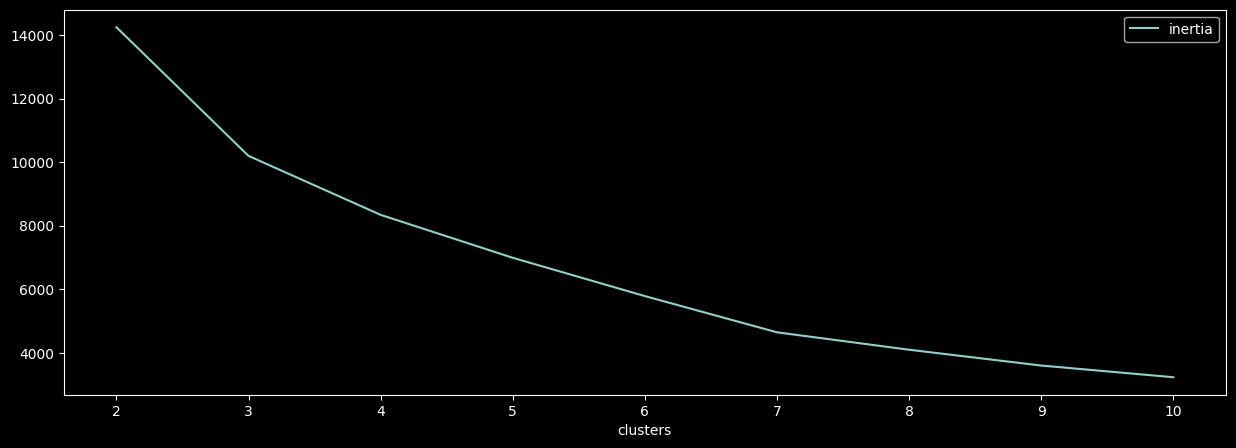

In [96]:
# Graph Inertia
temp_X_2.set_index("clusters")["inertia"].plot(figsize=(15,5), legend=True)

<AxesSubplot: xlabel='clusters'>

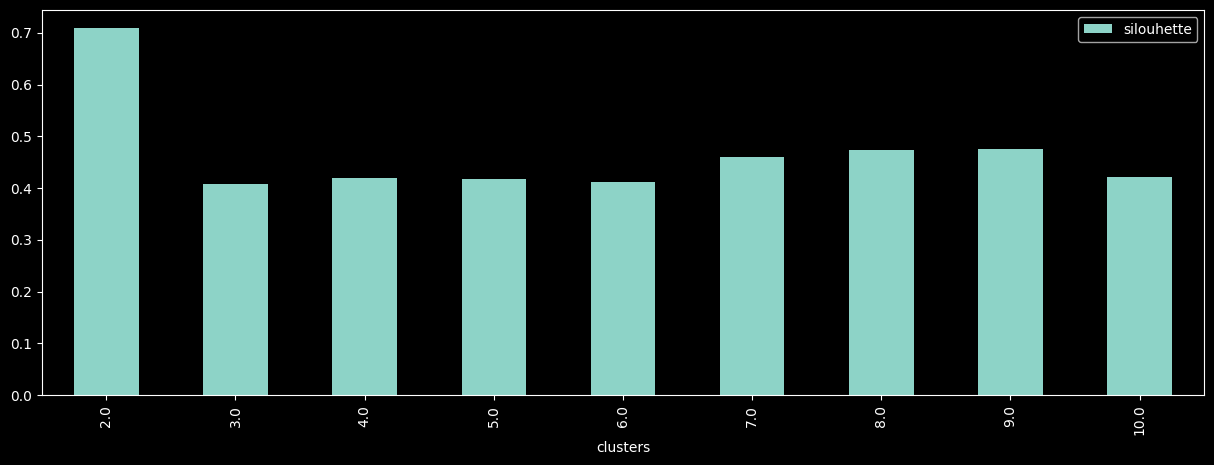

In [97]:
# Graph Silhouette
temp_X_2.set_index("clusters")["silouhette"].plot(kind='bar', figsize=(15,5), legend=True)

In [98]:
km = KMeans(n_clusters=4, random_state=0) # 7 clusters
km.fit(X_2)
predictions = km.predict(X_2)

/Users/pryda/.pyenv/versions/3.11.0/envs/bootcamp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [99]:
df_sample.loc[:,'Cluster_KMeans_X_2'] = predictions
df_sample.head()

Lat      Lon  DayOfWeek  Hour Hour_DayOfWeek  Cluster_KMeans_X_2
255777   40.7588 -73.9726          3    20           20_3                   0
2591794  40.7806 -73.9582          4    17           17_4                   0
1384006  40.7399 -73.9823          3    22           22_3                   0
530592   40.6449 -73.7824          0    16           16_0                   1
3679163  40.7708 -73.8656          6     9            9_6                   2

In [109]:
fig = px.scatter_mapbox(df_sample, lat="Lat", lon="Lon", color="Cluster_KMeans_X_2", mapbox_style="carto-positron", zoom=10, height=500, width=800)
fig.show()

## KMeans Finding Optimal Clusters with Inertia/Silhouette for 4 features

In [101]:
silhouette_scores = []
inertias = []
n_clusters = []

for n_cluster in range(2,11):
    km = KMeans(n_clusters=n_cluster)
    km.fit(X_4)
    predictions = km.predict(X_4)
    silhouette_scores.append(silhouette_score(X_4, predictions))
    inertias.append(km.inertia_)
    n_clusters.append(n_cluster)

### Create dataframe
temp_X_4 = pd.DataFrame([n_clusters, silhouette_scores, inertias]).T.rename(columns={0:"clusters", 1:"silouhette", 2:"inertia"})
temp_X_4

/Users/pryda/.pyenv/versions/3.11.0/envs/bootcamp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/pryda/.pyenv/versions/3.11.0/envs/bootcamp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/pryda/.pyenv/versions/3.11.0/envs/bootcamp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/pryda/.pyenv/versions/3.11.0/envs/bootcamp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

clusters  silouhette       inertia
0       2.0    0.224184  32616.710260
1       3.0    0.246543  27251.945574
2       4.0    0.262656  22414.042413
3       5.0    0.267905  20011.983860
4       6.0    0.256319  17946.112141
5       7.0    0.239685  16489.996932
6       8.0    0.268011  15424.780676
7       9.0    0.233764  14633.637353
8      10.0    0.242544  13400.830660

<AxesSubplot: xlabel='clusters'>

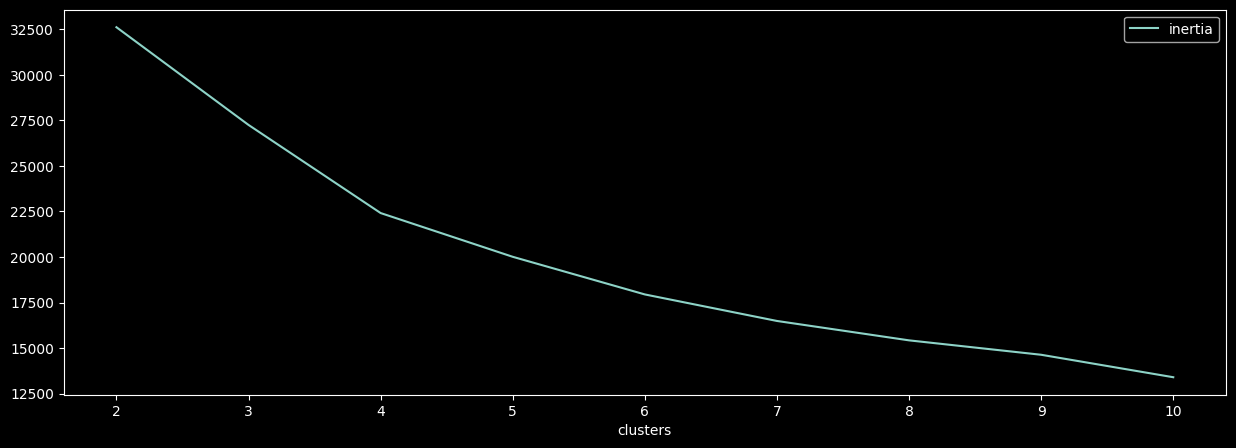

In [102]:
# Graph Inertia
temp_X_4.set_index("clusters")["inertia"].plot(figsize=(15,5), legend=True)

<AxesSubplot: xlabel='clusters'>

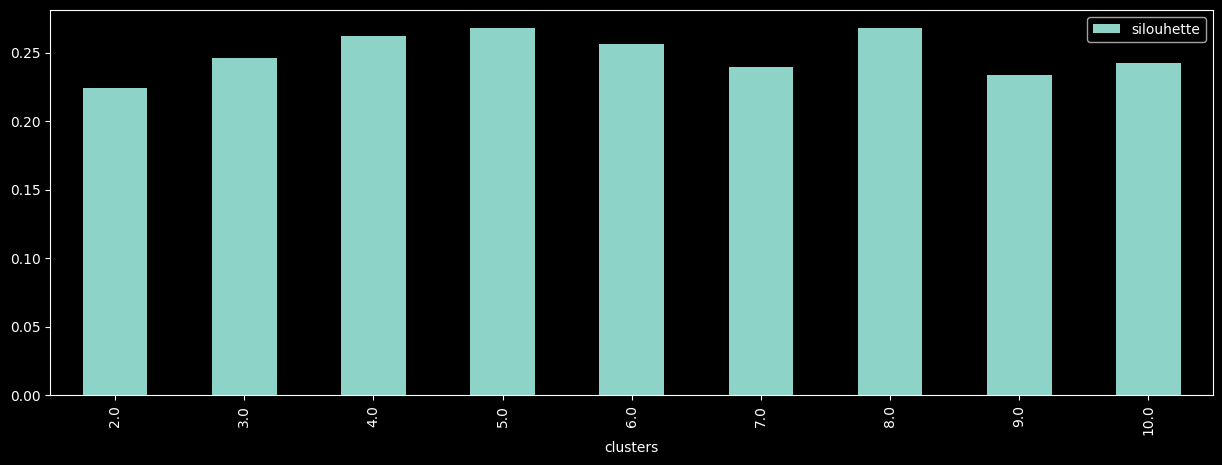

In [103]:
# Graph Silhouette
temp_X_4.set_index("clusters")["silouhette"].plot(kind='bar', figsize=(15,5), legend=True)

In [104]:
km = KMeans(n_clusters=4, random_state=0)
km.fit(X_4)
predictions = km.predict(X_4)

df_sample.loc[:,'Cluster_KMeans_X_4'] = predictions
df_sample.head()

/Users/pryda/.pyenv/versions/3.11.0/envs/bootcamp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Lat      Lon  DayOfWeek  Hour Hour_DayOfWeek  Cluster_KMeans_X_2  \
255777   40.7588 -73.9726          3    20           20_3                   0   
2591794  40.7806 -73.9582          4    17           17_4                   0   
1384006  40.7399 -73.9823          3    22           22_3                   0   
530592   40.6449 -73.7824          0    16           16_0                   1   
3679163  40.7708 -73.8656          6     9            9_6                   2   

         Cluster_KMeans_X_4  
255777                    1  
2591794                   1  
1384006                   1  
530592                    2  
3679163                   0

In [110]:
fig = px.scatter_mapbox(df_sample, lat="Lat", lon="Lon", color="Cluster_KMeans_X_4", mapbox_style="carto-positron", zoom=10, height=500, width=800)
fig.show()

# Hotzones KMeans (2 features)

In [111]:
centroid_dict = {i: [df_sample[df_sample["Cluster_KMeans_X_2"] == i]["Lon"].mean(), df_sample[df_sample["Cluster_KMeans_X_2"] == i]["Lat"].mean()] for i in df_sample["Cluster_KMeans_X_2"].unique()}
# create two columns latitude and longitude for the corresponding cluster centroid
df_sample["KMeans_Cluster_X_2_Lat"] = df_sample["Cluster_KMeans_X_2"].map(lambda x: centroid_dict[x][1])
df_sample["KMeans_Cluster_X_2_Lon"] = df_sample["Cluster_KMeans_X_2"].map(lambda x: centroid_dict[x][0])

In [113]:
# Map of clusters centroids
fig = px.scatter_mapbox(df_sample[df_sample["Cluster_KMeans_X_2"] != -1], lat="KMeans_Cluster_X_2_Lat", lon="KMeans_Cluster_X_2_Lon", color="Cluster_KMeans_X_2", zoom=8, mapbox_style="carto-positron", animation_frame="Hour_DayOfWeek", category_orders=category_order, height=500, width=800)
fig.show()

# DBSCAN
## 2 Features

In [114]:
# Instanciate DBSCAN 
db_2 = DBSCAN(eps=0.11, min_samples=50, metric="manhattan", n_jobs=-1, algorithm="brute").fit(X_2) 
labels = db_2.labels_
df_sample["DBSCAN_Cluster_X_2"] = labels

In [117]:
fig = px.scatter_mapbox(df_sample[df_sample["DBSCAN_Cluster_X_2"] != -1], lat="Lat", lon="Lon", color="DBSCAN_Cluster_X_2", zoom=8, mapbox_style="carto-positron",height=500, width=800)
fig.show()

# Hotzones DBScan 

In [ ]:
centroid_dict = {i: [df_sample[df_sample["DBSCAN_Cluster_X_2"] == i]["Lon"].mean(), df_sample[df_sample["DBSCAN_Cluster_X_2"] == i]["Lat"].mean()] for i in df_sample["DBSCAN_Cluster_X_2"].unique()}
# create two columns latitude and longitude for the corresponding cluster centroid
df_sample["DBSCAN_Cluster_X_2_Lat"] = df_sample["DBSCAN_Cluster_X_2"].map(lambda x: centroid_dict[x][1])
df_sample["DBSCAN_Cluster_X_2_Lon"] = df_sample["DBSCAN_Cluster_X_2"].map(lambda x: centroid_dict[x][0])

In [ ]:
# Map of clusters centroids
fig = px.scatter_mapbox(df_sample[df_sample["DBSCAN_Cluster_X_2"] != -1], lat="DBSCAN_Cluster_X_2_Lat", lon="DBSCAN_Cluster_X_2_Lon", color="DBSCAN_Cluster_X_2", zoom=8, mapbox_style="carto-positron", animation_frame="Hour_DayOfWeek", category_orders=category_order, height=500, width=800)
fig.show()

## 4 Features


In [118]:
# Instanciate DBSCAN 
db_4 = DBSCAN(eps=0.11, min_samples=10, metric="manhattan", n_jobs=-1, algorithm="brute").fit(X_4) 
labels = db_4.labels_
df_sample["DBSCAN_Cluster_X_4"] = labels

In [119]:
fig = px.scatter_mapbox(df_sample[df_sample["DBSCAN_Cluster_X_4"] != -1], lat="Lat", lon="Lon", color="DBSCAN_Cluster_X_4", mapbox_style="carto-positron", zoom=10, height=500, width=800)
fig.show()